# Sensor Anomaly Detection

A seguir será aoresentado um algoritmo de inteligência artificial chamado <i>AutoEncoder</i>, que irá fazer detecção de anomalias em dados sensoriais de rolamentos.

In [1]:
import os
import numpy
import pandas
import seaborn
import tensorflow
from matplotlib import pyplot
from sklearn import preprocessing
from tensorflow.keras import activations, layers, losses, models, optimizers, regularizers

In [2]:
seaborn.set(color_codes=True)
try:
    device = tensorflow.config.experimental.list_physical_devices("GPU")[0]
except:
    print("No GPU avaliable!")
else:
    try:
        tensorflow.config.experimental.set_memory_growth(device, True)
    except:
        print("Could not enable dynamic memory growth on device " + str(device))
    else:
        print("Using device " + str(device))

Using device PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Leitura E Análise Dos Dados

Como não é possível obter dados reais do porto de Santos, foram utilizados dados públicos relacionados ao movimento angular de rolamentos que estão em bom funcionamento e que estão desgastados, e portanto, com funcionamento errático.

In [3]:
data_dir = os.path.join("data", "sensor_data")
merged_data = pandas.DataFrame()

for filename in os.listdir(data_dir):
    dataset = pandas.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = numpy.array(dataset.abs().mean())
    dataset_mean_abs = pandas.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)
    
merged_data.columns = ["Bearing 1", "Bearing 2", "Bearing 3", "Bearing 4"]

In [4]:
merged_data.index = pandas.to_datetime(merged_data.index, format="%Y.%m.%d.%H.%M.%S")
merged_data = merged_data.sort_index()
merged_data.to_csv("Averaged_BearingTest_Dataset.csv")
print("Dataset shape:", merged_data.shape)

Dataset shape: (982, 4)


In [5]:
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


In [6]:
train = merged_data["2004-02-12 10:52:39":"2004-02-15 12:52:39"]
test = merged_data["2004-02-15 12:52:39":]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (445, 4)
Test dataset shape: (538, 4)


C:\tools\miniconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


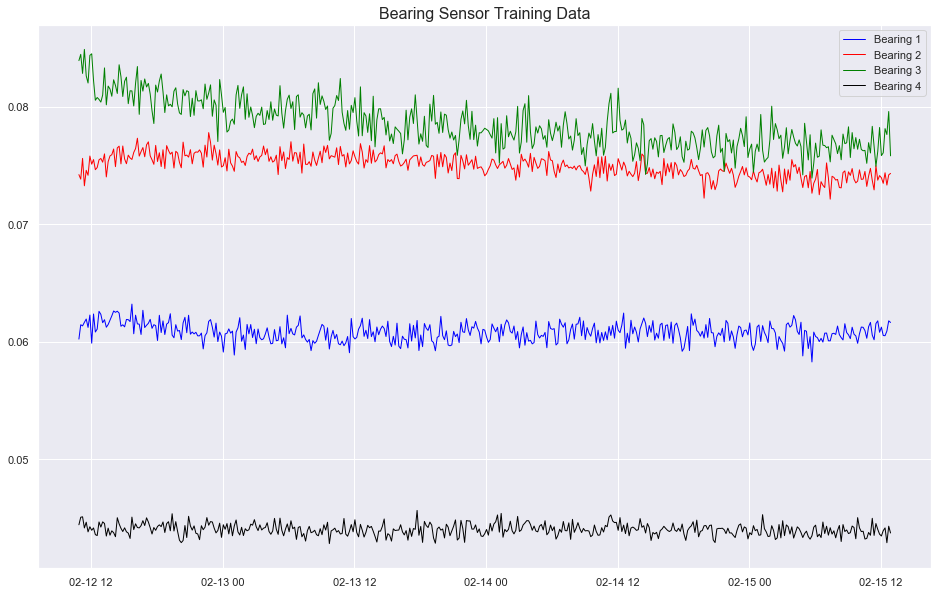

In [7]:
_, axis = pyplot.subplots(figsize=(16, 10))
axis.plot(train["Bearing 1"], label="Bearing 1", color="blue", animated = True, linewidth=1)
axis.plot(train["Bearing 2"], label="Bearing 2", color="red", animated = True, linewidth=1)
axis.plot(train["Bearing 3"], label="Bearing 3", color="green", animated = True, linewidth=1)
axis.plot(train["Bearing 4"], label="Bearing 4", color="black", animated = True, linewidth=1)
pyplot.legend(loc="upper right")
axis.set_title("Bearing Sensor Training Data", fontsize=16)
pyplot.show()

In [8]:
train_fft = numpy.fft.fft(train)
test_fft = numpy.fft.fft(test)

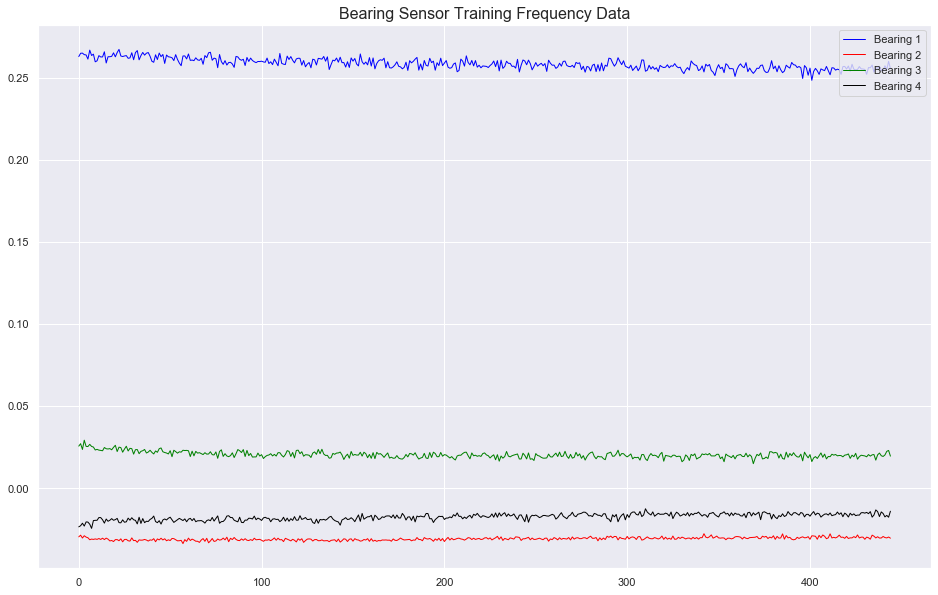

In [9]:
_, axis = pyplot.subplots(figsize=(16, 10))
axis.plot(train_fft[:,0].real, label="Bearing 1", color="blue", animated = True, linewidth=1)
axis.plot(train_fft[:,1].imag, label="Bearing 2", color="red", animated = True, linewidth=1)
axis.plot(train_fft[:,2].real, label="Bearing 3", color="green", animated = True, linewidth=1)
axis.plot(train_fft[:,3].real, label="Bearing 4", color="black", animated = True, linewidth=1)
pyplot.legend(loc="upper right")
axis.set_title("Bearing Sensor Training Frequency Data", fontsize=16)
pyplot.show()

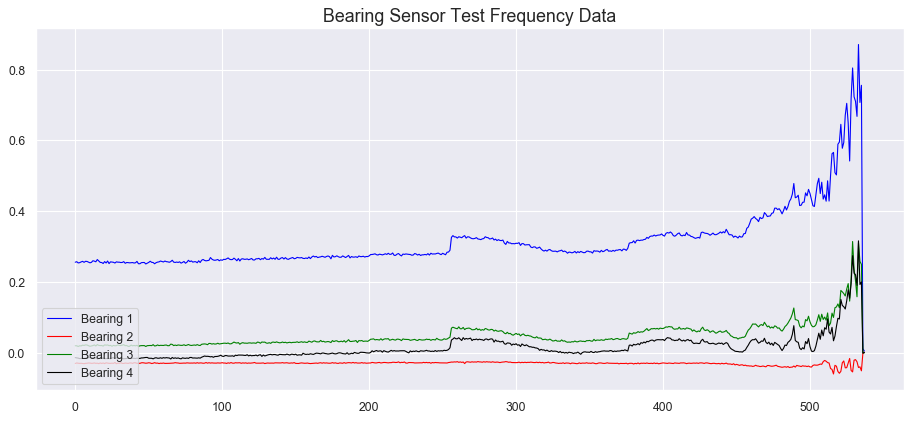

In [10]:
_, axis = pyplot.subplots(figsize=(14, 6), dpi=80)
axis.plot(test_fft[:,0].real, label="Bearing 1", color="blue", animated = True, linewidth=1)
axis.plot(test_fft[:,1].imag, label="Bearing 2", color="red", animated = True, linewidth=1)
axis.plot(test_fft[:,2].real, label="Bearing 3", color="green", animated = True, linewidth=1)
axis.plot(test_fft[:,3].real, label="Bearing 4", color="black", animated = True, linewidth=1)
pyplot.legend(loc='lower left')
axis.set_title("Bearing Sensor Test Frequency Data", fontsize=16)
pyplot.show()

In [11]:
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)

In [12]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (445, 1, 4)
Test data shape: (538, 1, 4)


In [13]:
def autoencoder(X):
    model = models.Sequential()
    model.add(layers.Input(shape=(X.shape[1], X.shape[2])))
    model.add(layers.GRU(128, activation=activations.linear, return_sequences=True,  kernel_regularizer=regularizers.l2(0.00)))
    model.add(layers.LeakyReLU())
    model.add(layers.GRU(64, activation=activations.linear, return_sequences=False))
    model.add(layers.LeakyReLU())
    model.add(layers.RepeatVector(X.shape[1]))
    model.add(layers.GRU(64, activation=activations.linear, return_sequences=True))
    model.add(layers.LeakyReLU())
    model.add(layers.GRU(128, activation=activations.linear, return_sequences=True))
    model.add(layers.LeakyReLU())
    model.add(layers.TimeDistributed(layers.Dense(X.shape[2])))
    return model

In [14]:
model = autoencoder(X_train)
model.compile(optimizer=optimizers.Adam(), loss=losses.MeanSquaredError())
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 128)            51456     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1, 128)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 64)             0         
_________________________________________________________________
gru_2 (GRU)                  (None, 1, 64)             24960     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1, 64)             0

In [15]:
history = model.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.25)

Train on 333 samples, validate on 112 samples
Epoch 1/10
333/333 [==============================] - 11s 34ms/sample - loss: 0.2552 - val_loss: 0.1190
Epoch 2/10
333/333 [==============================] - 0s 665us/sample - loss: 0.1670 - val_loss: 0.0412
Epoch 3/10
333/333 [==============================] - 0s 519us/sample - loss: 0.0433 - val_loss: 0.0635
Epoch 4/10
333/333 [==============================] - 0s 458us/sample - loss: 0.0252 - val_loss: 0.0223
Epoch 5/10
333/333 [==============================] - 0s 461us/sample - loss: 0.0229 - val_loss: 0.0327
Epoch 6/10
333/333 [==============================] - 0s 489us/sample - loss: 0.0206 - val_loss: 0.0293
Epoch 7/10
333/333 [==============================] - 0s 461us/sample - loss: 0.0201 - val_loss: 0.0280
Epoch 8/10
333/333 [==============================] - 0s 442us/sample - loss: 0.0191 - val_loss: 0.0285
Epoch 9/10
333/333 [==============================] - 0s 461us/sample - loss: 0.0185 - val_loss: 0.0260
Epoch 10/10
333/33

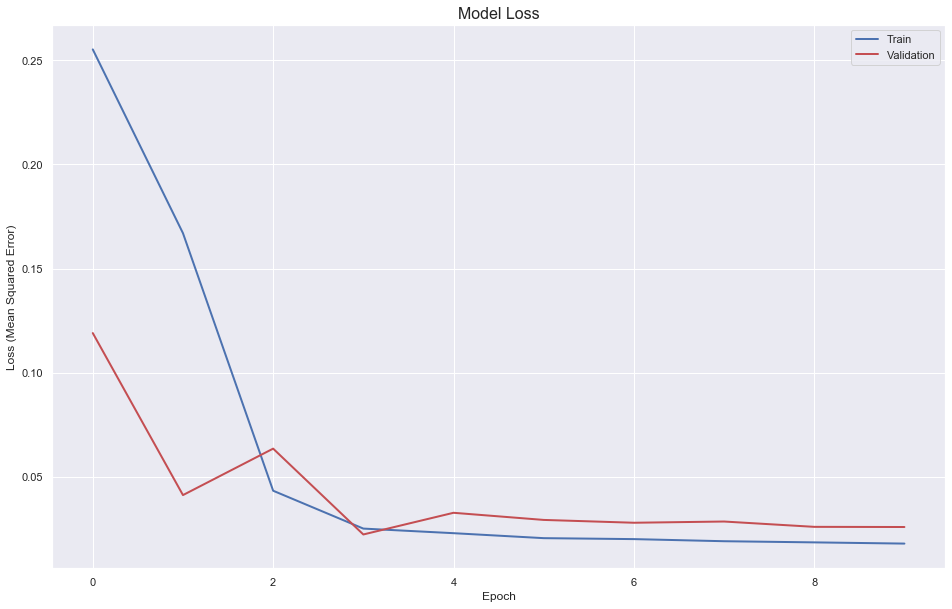

In [16]:
_, axis = pyplot.subplots(figsize=(16, 10))
loss = history.history["loss"]
val_loss = history.history["val_loss"]
axis.plot(loss, 'b', label="Train", linewidth=2)
axis.plot(val_loss, 'r', label="Validation", linewidth=2)
axis.set_title("Model Loss", fontsize=16)
axis.set_ylabel("Loss (Mean Squared Error)")
axis.set_xlabel("Epoch")
axis.legend(loc='upper right')
pyplot.show()

In [17]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pandas.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

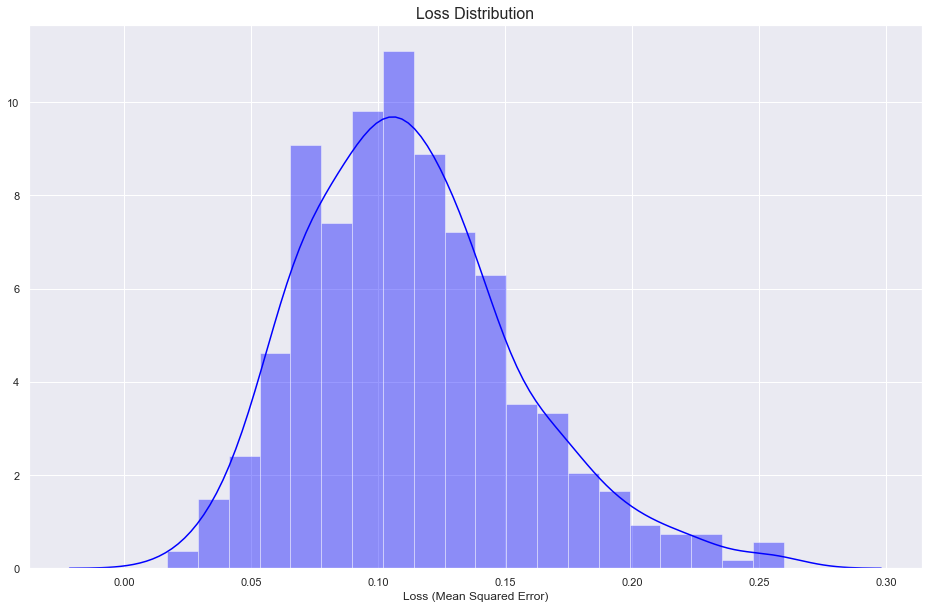

In [18]:
scored = pandas.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored["Loss (Mean Squared Error)"] = numpy.mean(numpy.abs(X_pred - Xtrain), axis=1)
pyplot.figure(figsize=(16, 10))
pyplot.title("Loss Distribution", fontsize=16)
seaborn.distplot(scored["Loss (Mean Squared Error)"], bins = 20, kde= True, color = 'blue')
pyplot.show()

In [19]:
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pandas.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

In [20]:
scored = pandas.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored["Loss (Mean Squared Error)"] = numpy.mean(numpy.abs(X_pred - Xtest), axis=1)
scored["Threshold"] = 0.275
scored["Anomaly"] = scored["Loss (Mean Squared Error)"] > scored["Threshold"]
scored.head()

,Loss (Mean Squared Error),Threshold,Anomaly
2004-02-15 12:52:39,0.167588,0.275,False
2004-02-15 13:02:39,0.220007,0.275,False
2004-02-15 13:12:39,0.131474,0.275,False
2004-02-15 13:22:39,0.117667,0.275,False
2004-02-15 13:32:39,0.095612,0.275,False


In [21]:
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pandas.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

In [22]:
scored_train = pandas.DataFrame(index=train.index)
scored_train["Loss (Mean Squared Error)"] = numpy.mean(numpy.abs(X_pred_train - Xtrain), axis=1)
scored_train["Threshold"] = 0.275
scored_train["Anomaly"] = scored_train["Loss (Mean Squared Error)"] > scored_train["Threshold"]
scored = pandas.concat([scored_train, scored])

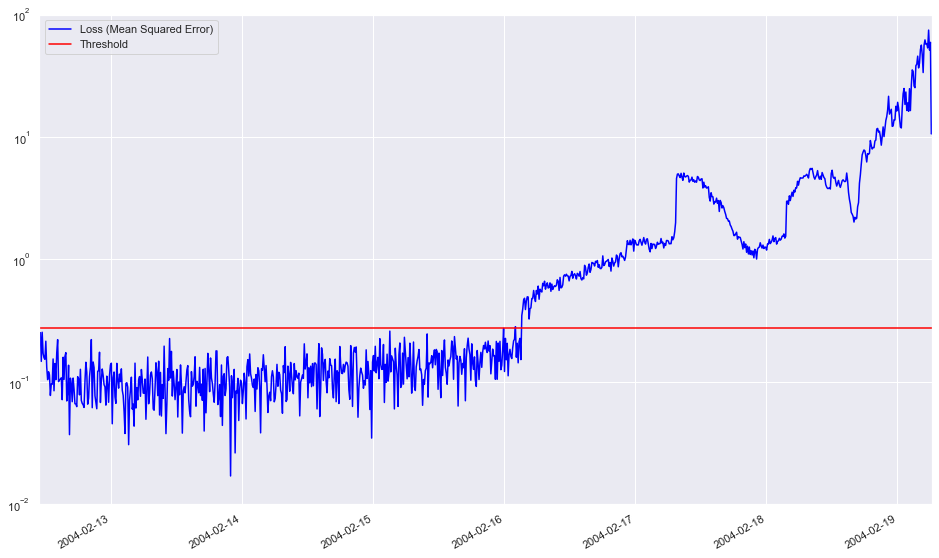

In [23]:
scored.plot(logy=True,  figsize=(16, 10), ylim=[1e-2,1e2], color=["blue", "red"])
pyplot.show()

Como é possível perceber, o modelo conseguiu boas classificações em dados de rolamentos em funcionamento normal (abaixo da curva vermelha) e de comportamento indicativo de falhas (acima da curva vermelha).